In [1]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from google.cloud.language import enums
from google.cloud.language import types
import six
from google.cloud import storage
from google.cloud import language
from google.oauth2 import service_account
import numpy as np
from matplotlib import pyplot as plt

In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jono/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/jono/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jono/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
#google cloud nlp api which we will use for speach tagging and extracting keywords
#You will need a json file from google to use their language API
creds = service_account.Credentials.from_service_account_file('xxxxxx.json')
client = language.LanguageServiceClient(credentials=creds)

In [48]:
#removing stop words from a sentence, special characters and dublicates
def preprocess(sentence):
    sentence = remove_special_characters(sentence)
    word_tokens = word_tokenize(sentence)
    filtered_words = [w for w in word_tokens if not w in stopwords.words('english')]
    
    return remove_dublicates_words(" ".join(filtered_words))

In [49]:
#removing stop words from a sentence and special characters
def preprocess_with_dublicates(sentence):
    sentence = remove_special_characters(sentence)
    word_tokens = word_tokenize(sentence)
    filtered_words = [w for w in word_tokens if not w in stopwords.words('english')]
    
    return " ".join(filtered_words)

In [50]:
#removing dublicate words in a sentence
def remove_dublicates_words(sent):
    word_tokens = word_tokenize(sent)
    tokens_list=[]
    for w in word_tokens:
        if w not in tokens_list:
            tokens_list.append(w)
    return " ".join(tokens_list)

In [51]:
#Removing special characters
def remove_special_characters(s):
    tokenizer = nltk.RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    tokens= tokenizer.tokenize(s)
    return " ".join(tokens)

In [52]:
#for each word, we return the word and the number of its appearances
def word_count(sent):
    word_tokens = word_tokenize(remove_special_characters(sent))
    non_dublicate_tokens=word_tokenize(remove_dublicates_words(remove_special_characters(sent)))
    word_count={}
    for n in non_dublicate_tokens:
        count=0
        for w in word_tokens:
            if n.lower() == w.lower():
                count+=1
        word_count[n]=count
        
    return word_count
        

In [98]:
def plot_word_frequency(text):
    x=word_count(text)
    lst_labels=[]
    lst_values=[]

    for k,v in x.items():
        if(v>1):
            lst_labels.append(k)
            lst_values.append(v)

    # sort your values in descending order
    indSort = np.argsort(lst_values)[::-1]

    # rearrange your data
    labels = np.array(lst_labels)[indSort]
    values = np.array(lst_values)[indSort]

    indexes = np.arange(len(labels))

    bar_width = 0.

    plt.bar(indexes, values)

    # add labels
    plt.xticks(indexes + bar_width, labels)
    plt.show()

In [99]:
def syntax_text(text):
    my_token_list=[]
    my_key_words=[]
    
    my_token_dict={}
    my_keywords_dict={}
    
    if isinstance(text, six.binary_type):
        text = text.decode('utf-8')

    # Instantiates a plain text document.
    document = types.Document(
        content=text,
        type=enums.Document.Type.PLAIN_TEXT)

    # Detects syntax in the document. You can also analyze HTML with:
    #   document.type == enums.Document.Type.HTML
    tokens = client.analyze_syntax(document).tokens

    # part-of-speech tags from enums.PartOfSpeech.Tag
    pos_tag = ('UNKNOWN', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM',
               'PRON', 'PRT', 'PUNCT', 'VERB', 'X', 'AFFIX')
    for token in tokens:
        my_token_list.append((pos_tag[token.part_of_speech.tag],
                               token.text.content))
        
        if pos_tag[token.part_of_speech.tag]=='NOUN':
            my_key_words.append(token.text.content)
            
    my_token_dict['Token_Tags']= my_token_list
    my_keywords_dict['keywords']=my_key_words
    
    return my_token_dict,my_keywords_dict

In [100]:
#Extracts from an article on Jamal Khashoggi's case cited from https://www.bbc.com/news/world-europe-45812399 
text="""

He first visited the Saudi consulate in Istanbul on 28 September to obtain a document certifying
that he had divorced his ex-wife, so that he could marry his Turkish fiancée.

But he was told he would have to return and arranged to come back on 2 October.

"He did not believe that something bad could happen on Turkish soil," his fiancée, 
Hatice Cengiz, wrote in the Washington Post.

"Jamal was hardly concerned ahead of his second visit."

"""

In [101]:
#Here we remove dublicate words and special characters as well as english stop words
preprocess(text)

'He first visited Saudi consulate Istanbul September obtain document certifying divorced ex wife could marry Turkish fiancée But told would return arranged come back October believe something bad happen soil Hatice Cengiz wrote Washington Post Jamal hardly concerned ahead second visit'

In [102]:
preprocess_with_dublicates(text)

'He first visited Saudi consulate Istanbul September obtain document certifying divorced ex wife could marry Turkish fiancée But told would return arranged come back October He believe something bad could happen Turkish soil fiancée Hatice Cengiz wrote Washington Post Jamal hardly concerned ahead second visit'

In [103]:
#from the pre-processed text, we extract keywords
syntax_text(preprocess(text))[1]

{'keywords': ['consulate',
  'Istanbul',
  'September',
  'document',
  'ex',
  'wife',
  'fiancée',
  'October',
  'something',
  'soil',
  'Hatice',
  'Cengiz',
  'Washington',
  'Post',
  'Jamal',
  'visit']}

In [104]:
#from the preprocessed text, for each word in the text we print the word and its corresponding tag
syntax_text(preprocess(text))[0]

{'Token_Tags': [('PRON', 'He'),
  ('ADV', 'first'),
  ('VERB', 'visited'),
  ('ADJ', 'Saudi'),
  ('NOUN', 'consulate'),
  ('NOUN', 'Istanbul'),
  ('NOUN', 'September'),
  ('VERB', 'obtain'),
  ('NOUN', 'document'),
  ('VERB', 'certifying'),
  ('VERB', 'divorced'),
  ('NOUN', 'ex'),
  ('NOUN', 'wife'),
  ('VERB', 'could'),
  ('VERB', 'marry'),
  ('ADJ', 'Turkish'),
  ('NOUN', 'fiancée'),
  ('CONJ', 'But'),
  ('VERB', 'told'),
  ('VERB', 'would'),
  ('VERB', 'return'),
  ('VERB', 'arranged'),
  ('VERB', 'come'),
  ('ADV', 'back'),
  ('NOUN', 'October'),
  ('VERB', 'believe'),
  ('NOUN', 'something'),
  ('ADJ', 'bad'),
  ('VERB', 'happen'),
  ('NOUN', 'soil'),
  ('NOUN', 'Hatice'),
  ('NOUN', 'Cengiz'),
  ('VERB', 'wrote'),
  ('NOUN', 'Washington'),
  ('NOUN', 'Post'),
  ('NOUN', 'Jamal'),
  ('ADV', 'hardly'),
  ('ADJ', 'concerned'),
  ('ADP', 'ahead'),
  ('ADJ', 'second'),
  ('NOUN', 'visit')]}

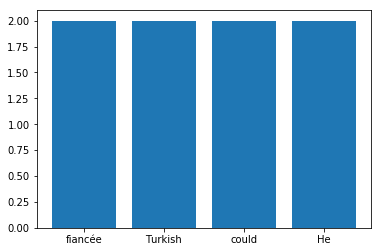

In [107]:
#plotting words with a frequency of more than 1
plot_word_frequency(preprocess_with_dublicates(text))

In [108]:
word_count(preprocess_with_dublicates(text))

{'He': 2,
 'first': 1,
 'visited': 1,
 'Saudi': 1,
 'consulate': 1,
 'Istanbul': 1,
 'September': 1,
 'obtain': 1,
 'document': 1,
 'certifying': 1,
 'divorced': 1,
 'ex': 1,
 'wife': 1,
 'could': 2,
 'marry': 1,
 'Turkish': 2,
 'fiancée': 2,
 'But': 1,
 'told': 1,
 'would': 1,
 'return': 1,
 'arranged': 1,
 'come': 1,
 'back': 1,
 'October': 1,
 'believe': 1,
 'something': 1,
 'bad': 1,
 'happen': 1,
 'soil': 1,
 'Hatice': 1,
 'Cengiz': 1,
 'wrote': 1,
 'Washington': 1,
 'Post': 1,
 'Jamal': 1,
 'hardly': 1,
 'concerned': 1,
 'ahead': 1,
 'second': 1,
 'visit': 1}